In [2]:
from torchvision import models, transforms
import torchvision
import torch
import torch.nn as nn

from utils import load_image

In [3]:
model_name = 'resnet50'
dir_name = f'result/{model_name}'
model_path = f'{dir_name}/{model_name}.pth'

def extract(target, inputs):
    feature = None

    def forward_hook(module, inputs, outputs):
        global features

        features = outputs.detach().clone()

    handle = target.register_forward_hook(forward_hook)

    model.eval()
    model(inputs)

    handle.remove()
    
    return features

def feature_to_img(feature, nrow=4):

    feature = feature.unsqueeze(1)

    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)

    img = transforms.functional.to_pil_image(img)
    
    new_w = 500
    new_h = int(new_w*img.height / img.width)
    img = img.resize((new_w, new_h))

    return img

In [4]:
device = torch.device("cuda")

model = models.resnet50(pretrained=False)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(2048,1, bias=True),  nn.Sigmoid())

model = model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
target_module = model.layer1[2].relu

inputs = load_image('result/resnet50/incorrect_mri/0/9.png')
transform = transforms.Compose([
    transforms.ToTensor(),
])

inputs = transform(inputs)
inputs = inputs.unsqueeze(0).to(device)

features = extract(target_module, inputs)
print(features.shape)

torch.Size([1, 256, 56, 56])


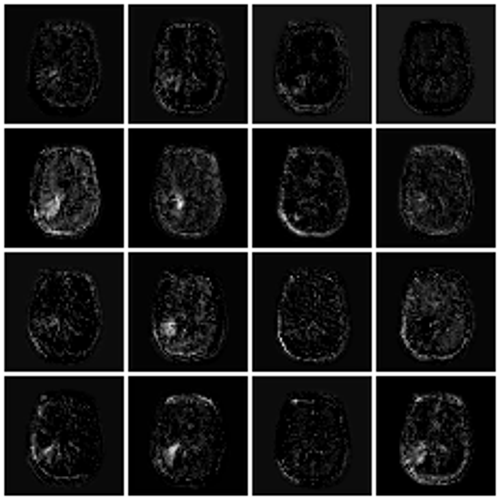

In [6]:
img = feature_to_img(features[0][:16])
img